<a href="https://colab.research.google.com/github/Aman-Singh-Akhand/QML-HEP-GSoC-2025/blob/main/Task_II_Classical_Graph_Neural_Network_(GNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 563.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy  as np

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

# --- Step 1: Load the Dataset ---
# Assuming your file is named 'QG_jets(1).npz' and contains arrays 'X' and 'y'
data = np.load('/content/QG_jets(1).npz')
X = data['X']  # shape: (100000, 139, 4)
y = data['y']  # shape: (100000,)

# Ensure proper data types and reshape y to (100000, 1)
X = X.astype('float32')
y = y.reshape(-1, 1).astype('float32')

print("X shape:", X.shape)
print("y shape:", y.shape)





# --- Step 3: Split Data into Training and Testing Sets ---
X_train, X_test, A_train, A_test, y_train, y_test = train_test_split(
    X, A_all, y, test_size=0.2, random_state=42)





X shape: (100000, 139, 4)
y shape: (100000, 1)
Adjacency matrices shape: (100000, 139, 139)


In [ ]:
# --- Step 2: Build Physics-Inspired Adjacency Matrices ---
def build_physics_adjacency(jet, k=8):
    """
    Build an adjacency matrix for one jet using k-NN in rapidity-azimuth space.
    Assumes jet is a NumPy array of shape (139, 4) where:
      - Column 1: rapidity (or pseudorapidity)
      - Column 2: azimuthal angle (φ)
    """
    # Use columns 1 and 2 for computing distances:
    coords = jet[:, 1:3]
    # Compute a binary k-NN graph (each node connected to its k nearest neighbors)
    A_sparse = kneighbors_graph(coords, n_neighbors=k, mode='connectivity', include_self=False)
    # Symmetrize the matrix to ensure an undirected graph:
    A_sym = A_sparse.maximum(A_sparse.transpose())
    return A_sym.toarray().astype('float32')

In [ ]:
# Loop over all jets to build an array of adjacency matrices
num_graphs, num_nodes, _ = X.shape
A_all = np.zeros((num_graphs, num_nodes, num_nodes), dtype='float32')
for i in range(num_graphs):
    A_all[i] = build_physics_adjacency(X[i], k=8)

print("Adjacency matrices shape:", A_all.shape)

In [ ]:
# --- Step 4: Define a Custom GCN Layer ---
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        """
        A simple graph convolution layer.
        :param output_dim: Number of output features.
        :param activation: Activation function (e.g., 'relu').
        """
        super(GraphConvolution, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # input_shape[0] corresponds to the node feature matrix: (batch, N, F)
        F_in = input_shape[0][-1]
        self.weight = self.add_weight(
            shape=(F_in, self.output_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='weight'
        )
        self.bias = self.add_weight(
            shape=(self.output_dim,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        super(GraphConvolution, self).build(input_shape)

    def call(self, inputs):
        X, A = inputs  # X: (batch, N, F), A: (batch, N, N)

        # Add self-loops: A_tilde = A + I
        batch_size = tf.shape(A)[0]
        N = tf.shape(A)[1]
        I = tf.eye(N, batch_shape=[batch_size])
        A_tilde = A + I

        # Compute the degree matrix D and its inverse square root
        D = tf.reduce_sum(A_tilde, axis=-1)
        D_inv_sqrt = tf.linalg.diag(tf.pow(D, -0.5))

        # Normalize the adjacency matrix: A_norm = D^{-1/2} * A_tilde * D^{-1/2}
        A_norm = tf.matmul(tf.matmul(D_inv_sqrt, A_tilde), D_inv_sqrt)

        # Apply the graph convolution: A_norm * X * weight + bias
        AX = tf.matmul(A_norm, X)
        output = tf.matmul(AX, self.weight) + self.bias

        if self.activation is not None:
            output = self.activation(output)
        return output


In [ ]:
# --- Step 5: Build the GCN Model for Graph-Level Classification ---
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

# Define input dimensions
N = num_nodes    # 139 nodes per graph
F_node = X.shape[2]  # 4 features per node
n_out = 1        # Binary classification output

# Define model inputs
X_in = Input(shape=(N, F_node), name='X_in')  # (batch, 139, 4)
A_in = Input(shape=(N, N), name='A_in')         # (batch, 139, 139)

# Two graph convolution layers
x = GraphConvolution(32, activation='relu')([X_in, A_in])
x = GraphConvolution(32, activation='relu')([x, A_in])

# Global sum pooling to get a graph-level representation
x = Lambda(lambda z: tf.reduce_sum(z, axis=1), name='global_sum_pool')(x)

# Final classification layer (sigmoid for binary classification)
output = Dense(n_out, activation='sigmoid')(x)


In [ ]:
# Build and compile the model
model = Model(inputs=[X_in, A_in], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 6: Train the Model ---
model.fit(
    x=[X_train, A_train],
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.1
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ X_in (InputLayer)         │ (None, 139, 4)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ A_in (InputLayer)         │ (None, 139, 139)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ graph_convolution_5       │ (None, 139, 32)        │            160 │ X_in[0][0], A_in[0][0] │
│ (GraphConvolution)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ graph_convolution_6       │ (None, 139, 32)        │          1,056 │ graph_convolution_5[0… │
│ (GraphConvolution)        │                        │                │ A_in[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_sum_pool (Lambda)  │ (None, 32)             │              0 │ graph_convolution_6[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ global_sum_pool[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.6486 - loss: 5.9651 - val_accuracy: 0.7379 - val_loss: 0.9795
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6901 - loss: 1.2317 - val_accuracy: 0.6766 - val_loss: 1.2108
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7018 - loss: 0.9825 - val_accuracy: 0.7474 - val_loss: 0.5603
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7023 - loss: 0.9099 - val_accuracy: 0.6605 - val_loss: 1.5303
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7123 - loss: 0.7760 - val_accuracy: 0.7510 - val_loss: 0.6735
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7175 - loss: 0.7456 - val_accuracy: 0.7023 - val_loss: 0.5750
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7263 - loss: 0.6445 - val_accuracy: 0.7444 - val_loss: 0.5223
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7324 -

Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7550 - loss: 0.5289 - val_accuracy: 0.7844 - val_loss: 0.4761
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.7618 - loss: 0.5135 - val_accuracy: 0.7634 - val_loss: 0.4860
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7730 - loss: 0.4950 - val_accuracy: 0.7866 - val_loss: 0.4688
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7759 - loss: 0.4885 - val_accuracy: 0.7845 - val_loss: 0.4651
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7775 - loss: 0.4843 - val_accuracy: 0.7890 - val_loss: 0.4752
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7811 - loss: 0.4769 - val_accuracy: 0.7778 - val_loss: 0.4757
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7803 - loss: 0.4775 - val_accuracy: 0.7719 - val_loss: 0.5079
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7816 -

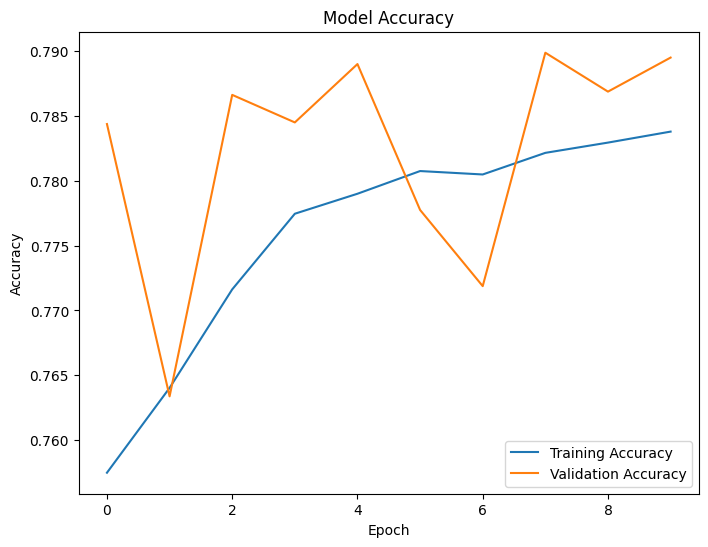

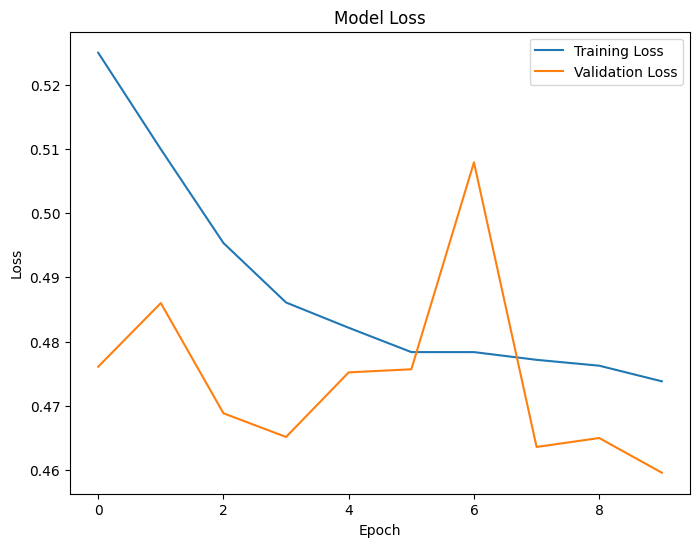

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the history
history = model.fit(
    x=[X_train, A_train],
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.1
)

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


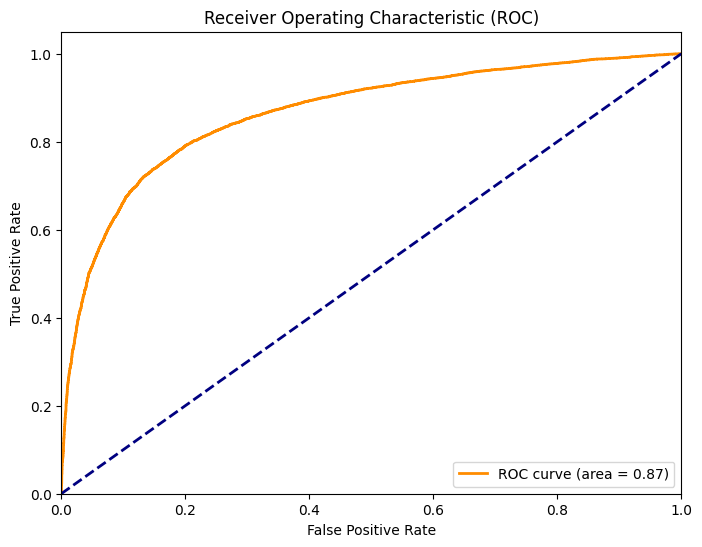

In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on test set
y_pred = model.predict([X_test, A_test]).ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


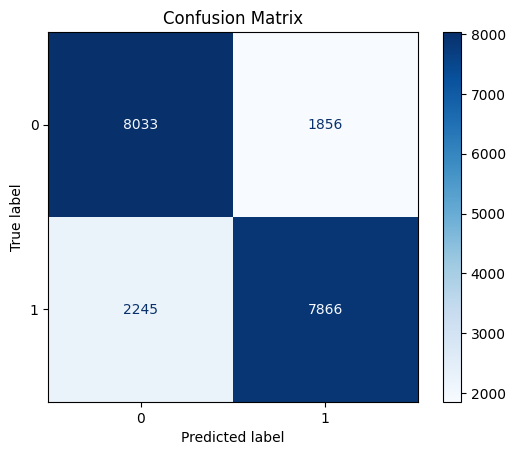

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Threshold predictions (0.5 cutoff for binary classification)
y_pred_label = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Graph Attention Network (GAT)

In [ ]:
!pip install spektral
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# --- Step 1: Load the Dataset ---
data = np.load('/content/QG_jets(1).npz')
# Get the number of data points
num_data_points = data['X'].shape[0]
sample_size = min(10000, num_data_points)

# Sample indices with a random state
rng = np.random.RandomState(42)  # Create a RandomState object with seed 42
sampled_indices = rng.choice(num_data_points, sample_size, replace=False)

# Get the sampled data for both X and y
X_sampled = data['X'][sampled_indices]
y_sampled = data['y'][sampled_indices]



In [ ]:
df_sampled

array([[[ 3.34407393e+00,  6.18760175e-01,  3.14677999e+00,
          2.20000000e+01],
        [ 1.53201063e-01,  5.97346645e-01,  3.04833095e+00,
          2.20000000e+01],
        [ 3.30795453e-01,  2.18555551e-01,  2.83228842e+00,
          2.20000000e+01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 2.34461674e+00, -4.67581002e-01,  2.59867005e+00,
         -2.11000000e+02],
        [ 1.71908994e+00, -2.22730584e-01,  2.85562985e+00,
         -2.11000000e+02],
        [ 1.14245519e-01, -5.40916154e-01,  3.21061055e+00,
          2.20000000e+01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.000

In [ ]:
X = X_sampled
y = y_sampled

# Ensure proper data types and reshape y to (100000, 1)
X = X.astype('float32')
y = y.reshape(-1, 1).astype('float32')

print("X shape:", X.shape)
print("y shape:", y.shape)




X shape: (10000, 139, 4)
y shape: (10000, 1)


In [ ]:
data['X'].shape[0]

100000

In [ ]:
# --- Step 2: Build Physics-Inspired Adjacency Matrices ---
def build_physics_adjacency(jet, k=8):
    """
    Build an adjacency matrix for one jet using k-NN in rapidity-azimuth space.
    Assumes jet is a NumPy array of shape (139, 4) where:
      - Column 1: rapidity (or pseudorapidity)
      - Column 2: azimuthal angle (φ)
    """
    # Use columns 1 and 2 for computing distances:
    coords = jet[:, 1:3]
    # Compute a binary k-NN graph (each node connected to its k nearest neighbors)
    A_sparse = kneighbors_graph(coords, n_neighbors=k, mode='connectivity', include_self=False)
    # Symmetrize the matrix to ensure an undirected graph:
    A_sym = A_sparse.maximum(A_sparse.transpose())
    return A_sym.toarray().astype('float32')


# Loop over all jets to build an array of adjacency matrices
num_graphs, num_nodes, _ = X.shape
A_all = np.zeros((num_graphs, num_nodes, num_nodes), dtype='float32')
for i in range(num_graphs):
    A_all[i] = build_physics_adjacency(X[i], k=8)

print("Adjacency matrices shape:", A_all.shape)





# --- Step 4: Define a Custom GCN Layer (Optional - You are using GAT) ---
# ... (You can keep this if you want to experiment with GCN later) ...





Adjacency matrices shape: (10000, 139, 139)


In [ ]:
# --- Step 3: Split Data into Training and Testing Sets ---
from sklearn.model_selection import train_test_split # Import the function here
X_train, X_test, A_train, A_test, y_train, y_test = train_test_split(
    X, A_all, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Lambda # Input is imported here
from tensorflow.keras.models import Model
# --- Step 5: Define the Graph Attention Layer ---
import tensorflow as tf

class GraphAttention(tf.keras.layers.Layer):
    def __init__(self, output_dim, attn_heads=1, activation=None, **kwargs):
        """
        Custom Graph Attention layer.
        :param output_dim: Output dimension per head.
        :param attn_heads: Number of attention heads.
        :param activation: Activation function (e.g., 'elu').
        """
        super(GraphAttention, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.attn_heads = attn_heads
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # input_shape[0] is the node feature matrix: (batch, N, F_in)
        F_in = input_shape[0][-1]
        # Weight matrix for transforming node features: shape (F_in, attn_heads * output_dim)
        self.W = self.add_weight(
            shape=(F_in, self.output_dim * self.attn_heads),
            initializer='glorot_uniform',
            name='W'
        )
        # Attention weight vector for each head: shape (attn_heads, 2 * output_dim)
        self.a = self.add_weight(
            shape=(self.attn_heads, 2 * self.output_dim),
            initializer='glorot_uniform',
            name='a'
        )
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
        super(GraphAttention, self).build(input_shape)

    def call(self, inputs):
        X, A = inputs  # X: (B, N, F_in), A: (B, N, N)
        batch_size = tf.shape(X)[0]
        N = tf.shape(X)[1]

        # Linear transformation: (B, N, attn_heads * output_dim)
        h = tf.matmul(X, self.W)
        # Reshape to: (B, N, attn_heads, output_dim)
        h = tf.reshape(h, (batch_size, N, self.attn_heads, self.output_dim))

        # Prepare pairwise comparisons:
        # h_i: (B, N, 1, attn_heads, output_dim)
        # h_j: (B, 1, N, attn_heads, output_dim)
        h_i = tf.expand_dims(h, axis=2)
        h_j = tf.expand_dims(h, axis=1)
        # Tile to obtain shape: (B, N, N, attn_heads, output_dim)
        h_i_tiled = tf.tile(h_i, [1, 1, N, 1, 1])
        h_j_tiled = tf.tile(h_j, [1, N, 1, 1, 1])

        # Concatenate the representations: (B, N, N, attn_heads, 2*output_dim)
        h_ij = tf.concat([h_i_tiled, h_j_tiled], axis=-1)

        # Expand self.a to shape (1, 1, 1, attn_heads, 2*output_dim) for broadcasting
        a_expanded = tf.expand_dims(tf.expand_dims(tf.expand_dims(self.a, 0), 0), 0)
        # Compute attention coefficients: perform element-wise multiplication and sum over last dimension
        e = tf.reduce_sum(h_ij * a_expanded, axis=-1)  # shape: (B, N, N, attn_heads)
        e = self.leaky_relu(e)

        # Apply the mask: A is (B, N, N); expand to (B, N, N, 1)
        mask = -10e9 * (1.0 - A)
        mask = tf.expand_dims(mask, axis=-1)
        e = e + mask  # shape remains (B, N, N, attn_heads)

        # Compute softmax over neighbor dimension (axis=2)
        attention = tf.nn.softmax(e, axis=2)  # shape: (B, N, N, attn_heads)

        # Aggregate the neighbor features weighted by attention:
        # Expand attention to (B, N, N, attn_heads, 1)
        attention = tf.expand_dims(attention, axis=-1)
        # Weighted sum over neighbors (axis=2): result shape (B, N, attn_heads, output_dim)
        h_prime = tf.reduce_sum(attention * h_j_tiled, axis=2)

        # Reshape to (B, N, attn_heads * output_dim)
        h_prime = tf.reshape(h_prime, (batch_size, N, self.attn_heads * self.output_dim))

        if self.activation is not None:
            h_prime = self.activation(h_prime)
        return h_prime








In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda

# Define input dimensions
N_nodes = 139   # Number of nodes per graph
F_node = 4      # Number of features per node
n_out = 1       # Binary classification output

# Model inputs
X_in = Input(shape=(N_nodes, F_node), name='X_in')
A_in = Input(shape=(N_nodes, N_nodes), name='A_in')

# First GAT layer: output dimension per head = 16, 2 heads → total output = 32
gat1 = GraphAttention(output_dim=16, attn_heads=2, activation='elu')([X_in, A_in])
# Second GAT layer
gat2 = GraphAttention(output_dim=16, attn_heads=2, activation='elu')([gat1, A_in])

# Global sum pooling to obtain a graph-level representation
pool = Lambda(lambda z: tf.reduce_sum(z, axis=1), name='global_sum_pool')(gat2)

# Final classification layer
output = Dense(n_out, activation='sigmoid')(pool)

# Build and compile the model
model_gat = Model(inputs=[X_in, A_in], outputs=output)
model_gat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gat.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ X_in (InputLayer)         │ (None, 139, 4)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ A_in (InputLayer)         │ (None, 139, 139)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ graph_attention           │ (None, 139, 32)        │            192 │ X_in[0][0], A_in[0][0] │
│ (GraphAttention)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ graph_attention_1         │ (None, 139, 32)        │          1,088 │ graph_attention[0][0], │
│ (GraphAttention)          │                        │                │ A_in[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_sum_pool (Lambda)  │ (None, 32)             │              0 │ graph_attention_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             33 │ global_sum_pool[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Step 7: Train the Model ---
history = model_gat.fit(
    x=[X_train, A_train],
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.1
)


# --- Step 8: Evaluate the Model ---
# ... (Code for plotting accuracy, loss, ROC curve, confusion matrix remains the same) ...

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.5373 - loss: 56.4178 - val_accuracy: 0.5450 - val_loss: 6.1855
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.5831 - loss: 9.0389 - val_accuracy: 0.5763 - val_loss: 11.0848
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - accuracy: 0.5859 - loss: 9.3281 - val_accuracy: 0.5725 - val_loss: 5.3576
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - accuracy: 0.5943 - loss: 6.4874 - val_accuracy: 0.5750 - val_loss: 12.6005
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.5921 - loss: 10.0158 - val_accuracy: 0.5562 - val_loss: 4.9210
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.5953 - loss: 5.6185 - val_accuracy: 0.6637 - val_loss: 4.5136
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 594s 3s/step - accuracy: 0.5959 - loss: 5.8355 - val_accuracy: 0.6662 - val_loss: 4.7669
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.5973 - loss: 6.1644 - val_

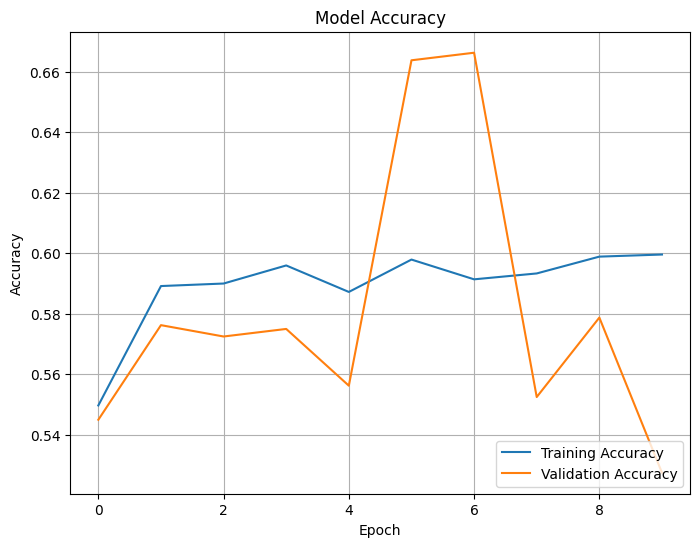

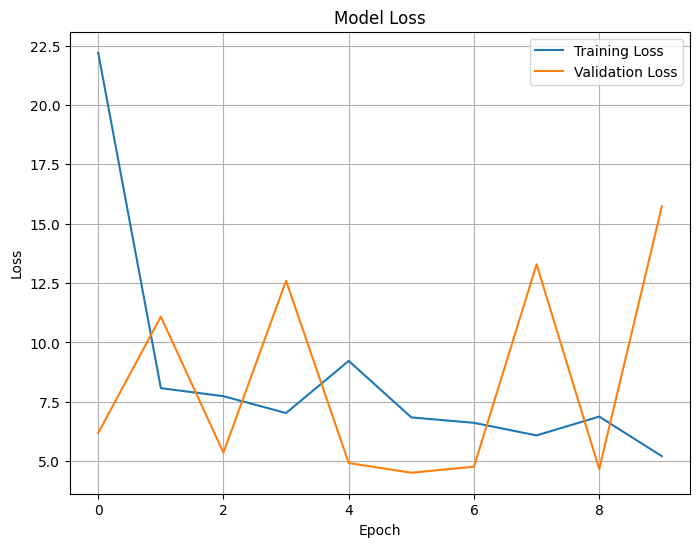

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_probs = model_gat.predict([X_test, A_test])  # for GCN or GAT input
y_pred = np.argmax(y_pred_probs, axis=1)        # predicted labels
y_true = np.argmax(y_test, axis=1)              # true labels if one-hot encoded


63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 816ms/step


In [ ]:
y_pred_probs

array([[1.2205171e-25],
       [9.3911588e-01],
       [4.2232959e-09],
       ...,
       [1.0953762e-09],
       [5.3259092e-10],
       [8.4257196e-18]], dtype=float32)